In [1]:
import numpy as np
import consts
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from datetime import datetime

In [10]:
"""
Generate synthetic data for UKF
"""

from typing import Tuple
from quat import prop_matrix
from sensors import acc_read
import numpy as np
from consts import N, dt, sig_gy_w, sig_gy_b, sig_acc
import scipy
from scipy.integrate import cumulative_trapezoid

def gen_data() -> Tuple:
    """
    Returns noisy gyro and accel, as well as GT attitude
    """

    # Generate gt angular velocity
    gt_omega = np.zeros((N, 3, 1))
    num_acc_steps = 20
    for i in range(3):
        acc_fn = scipy.interpolate.interp1d(
            np.arange(num_acc_steps + 1),
            np.random.randn(num_acc_steps + 1) * 1e-2,
            kind="cubic",
        )
        gt_omega[:, i, 0] = cumulative_trapezoid(
            acc_fn(np.linspace(0, num_acc_steps, N)), dx=dt, initial=0, axis=0
        )

    # Generate gt attitude
    gt_q = np.zeros((N, 4, 1))
    gt_q[0, :, 0] = np.array([0, 0, 0, 1])
    for i in range(1, N):
        gt_q[i] = prop_matrix(gt_omega[i]) @ gt_q[i - 1]
        # normalize
        gt_q[i] /= np.linalg.norm(gt_q[i])

    gt_bias_drift = np.random.randn(N, 3, 1) * sig_gy_b
    gt_bias = cumulative_trapezoid(gt_bias_drift, dx=dt, initial=0, axis=0)
    # gt_bias += np.random.randn(3, 1) * sig_gy_b * 10 # Jump start the bias
    # gt_bias = np.zeros((N, 3, 1))

    noisy_omega = gt_omega + gt_bias + np.random.randn(N, 3, 1) * sig_gy_w
    noisy_acc = np.zeros((N, 3, 1))
    for i in range(N):
        noisy_acc[i] = acc_read(gt_q[i]) + np.random.randn(3, 1) * sig_acc

    return gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc
gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc = gen_data()

In [3]:
def gen_save_data():
    gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc = gen_data()
    sig_gy_b = consts.sig_gy_b
    sig_gy_w = consts.sig_gy_w
    sig_acc = consts.sig_acc
    dt = consts.dt

    np.savez_compressed(datetime.now().strftime("%Y%m%d-%H%M%S") + '.npz', gt_q=gt_q, gt_omega=gt_omega, gt_bias=gt_bias, noisy_omega=noisy_omega, noisy_acc=noisy_acc, sig_gy_b=sig_gy_b, sig_gy_w=sig_gy_w, sig_acc=sig_acc, dt=dt)

# gen_save_data()

In [4]:
def load_data(path):
    data = np.load(path)
    gt_q = data["gt_q"]
    gt_omega = data["gt_omega"]
    gt_bias = data["gt_bias"]
    noisy_omega = data["noisy_omega"]
    noisy_acc = data["noisy_acc"]
    return gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc

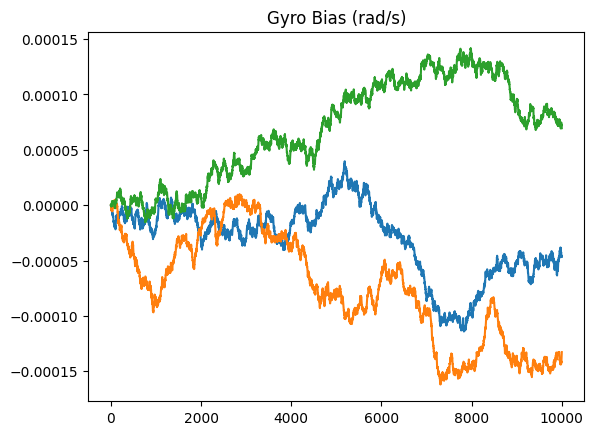

In [26]:
plt.plot(gt_bias[:, :, 0])
plt.title('Gyro Bias (rad/s)')
plt.savefig('gt_bias.png')

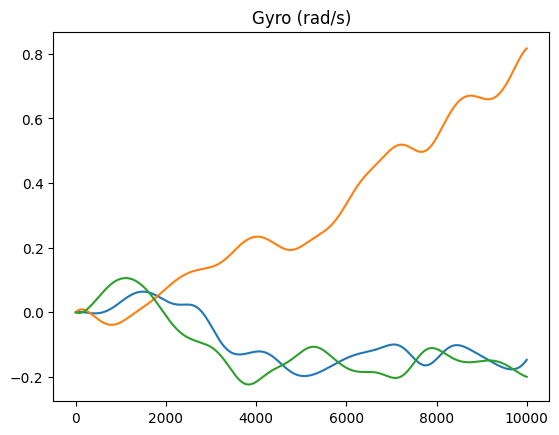

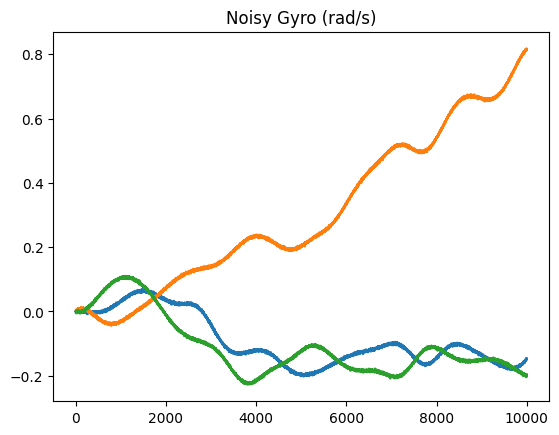

In [27]:
plt.plot(gt_omega[:, :, 0])
plt.title('Gyro (rad/s)')
plt.savefig('gt_omega.png')
plt.show()
plt.plot(noisy_omega[:, :, 0])
plt.title('Noisy Gyro (rad/s)')
plt.savefig('noisy_omega.png')

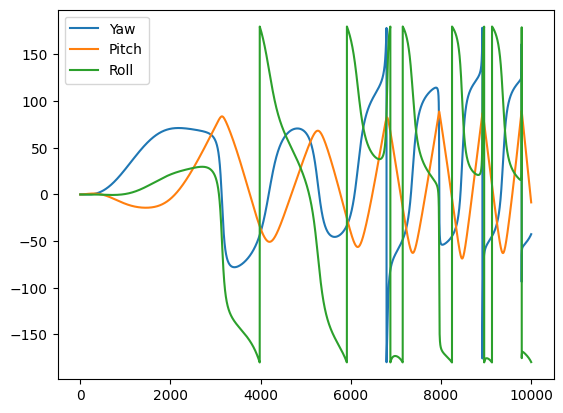

In [13]:
def plot_q(q: np.ndarray) -> None:
    assert q.shape[1] == 4
    q = q[:, :, 0]
    rot = R.from_quat(q)
    ypr = rot.as_euler("ZYX", degrees=True)
    plt.plot(ypr[:, 0], label="Yaw")
    plt.plot(ypr[:, 1], label="Pitch")
    plt.plot(ypr[:, 2], label="Roll")
    plt.legend()
    plt.show()

plot_q(gt_q)

In [14]:
from usque import run_ukf, DEFAULT_TYPE
from consts import n, N

# Initialize everything
x0 = np.array([[0, 0, 0, 0, 0, 0]], dtype=DEFAULT_TYPE).T
# P0 = diag([attitude err cov, bias err cov])
P0 = np.eye(n, dtype=DEFAULT_TYPE) * 1e-2

Y = noisy_acc  # IMU Accel observations
W = noisy_omega  # IMU Gyro observations

q, P = run_ukf(x0, P0, W, Y)

100%|██████████| 9999/9999 [00:24<00:00, 405.55it/s]


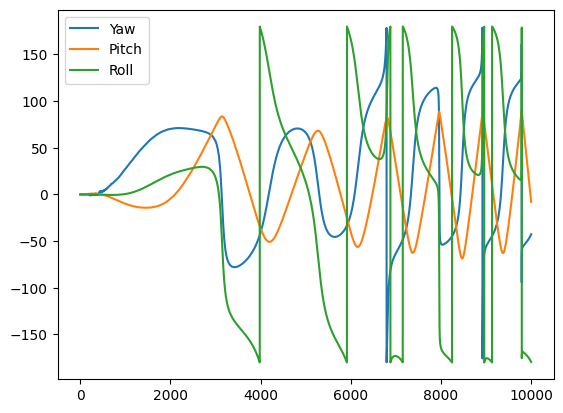

In [15]:
plot_q(q)


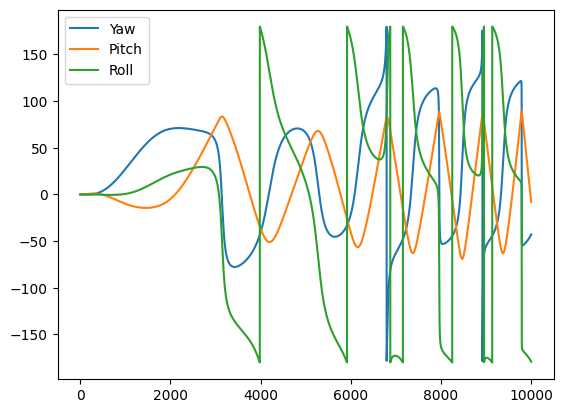

In [16]:
from quat import prop_matrix

naive_q = np.zeros((N, 4, 1))
naive_q[0, :, 0] = np.array([0, 0, 0, 1])
for i in range(1, N):
    naive_q[i] = prop_matrix(W[i]) @ naive_q[i - 1]
    # normalize
    naive_q[i] /= np.linalg.norm(naive_q[i])
    
plot_q(naive_q)

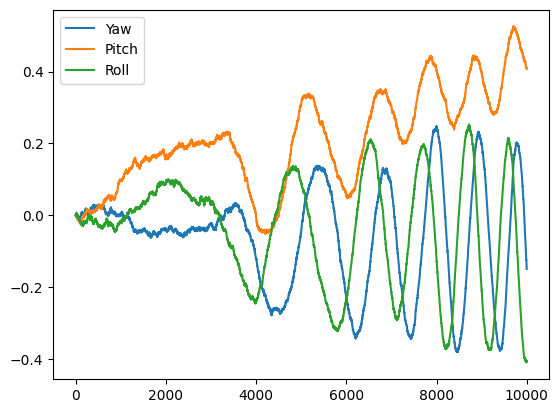

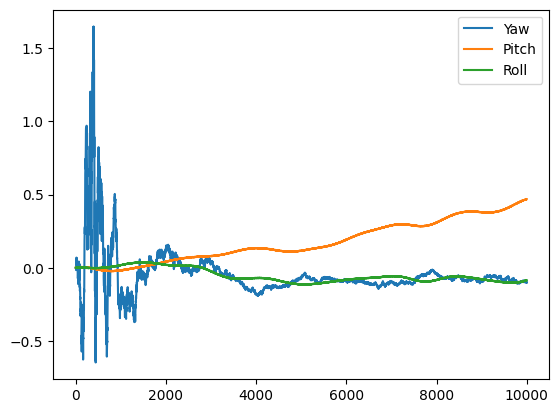

In [23]:
from quat import q_mul, q_inv

def get_err(q_est, q_gt):
    assert q_est.shape == q_gt.shape
    N, _, _ = q_est.shape
    q_err = np.zeros_like(q_est)
    for i in range(N):
        q_err[i] = q_mul(q_inv(q_est[i]), q_gt[i])
    
    rot_errs = R.from_quat(q_err[:, :, 0])
    plot_q(q_err)
    return rot_errs

errs = get_err(naive_q, gt_q)
errs2 = get_err(q, gt_q)